In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [24]:
pd.options.mode.copy_on_write = True

# Store Sales Forecasting: Getting started competition 

The goal is to forecast sales from Corporacion Favorita. The goal is to build a model for sales predicition for items sold at different stores. The score is RMSLE:

$E_{RMSLE} = \sqrt{\frac{1}{n} \sum_i^n \left( \log(1+y_i) - \log(1+\hat{y}_i) \right)^2 }$

## 1. Load Datasets

In [2]:
import pandas as pd

train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

## 2. Prepare Training and Validation Dataset

Setup a pipeline for feature engineering. 

In [71]:
def prepare_store_sales_dataset(df):
    """
    Prepares the dataset for learning from raw data. 
    Use the same pipeline both for train and test. 
    
    @param df: data to process 
    @returns: postprocessed data
    """
    X = pd.merge(stores, df, on='store_nbr') # add store data to train dataset
    # X = X.astype({"store_nbr":'str', "family":'str', "city":'str', "state":'str', "type":'str', "cluster":'str'})
    
    # TODO: cleanup
    #X = pd.concat([X, pd.get_dummies(X['family'])], axis=1).drop('family', axis=1)
    #X = pd.concat([X, pd.get_dummies(X['city']).add_suffix('_city')], axis=1).drop('city', axis=1)
    #X = pd.concat([X, pd.get_dummies(X['type'])], axis=1).drop('type', axis=1)
    #X = pd.concat([X, pd.get_dummies(X['state']).add_suffix('_state')], axis=1).drop('state', axis=1)

    
    X['date'] = pd.to_datetime(X['date'])
    X['year'] = X['date'].dt.year
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['day_of_week'] = X['date'].dt.dayofweek
    X = X.set_index('date')
  
    
    # X = X.drop('date', axis=1)
    return X 

# PREPARE FEATURES
X = prepare_store_sales_dataset(train)

# SPLIT TO TRAIN AND VALIDATE, BUT CAUSALLY: 
start = X.index[0]
end = X.index[-1]

split_fraction = 0.8
split_date = split_fraction*(end - start) + start

X_train = X[X.index < split_date]
X_valid = X[X.index >= split_date]

y_train = X_train['sales']
y_valid = X_valid['sales']

X_train.drop('sales', axis=1, inplace = True)
X_valid.drop('sales', axis=1, inplace = True)

# PREPARE THE TEST DATASET 
X_test = prepare_store_sales_dataset(test)

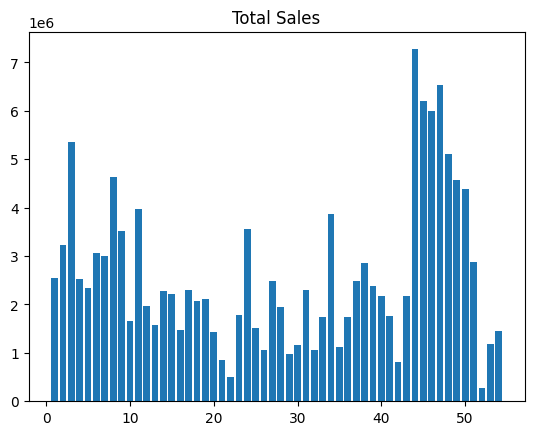

In [67]:
transaction_dict = transactions.groupby('store_nbr').sum().drop('date', axis=1)['transactions'].to_dict()
plt.bar(transaction_dict.keys(), transaction_dict.values());
plt.title("Total Sales");

In [ ]:
sns.histplot(x='type', y='sales', data=X)

In [ ]:
X

### 

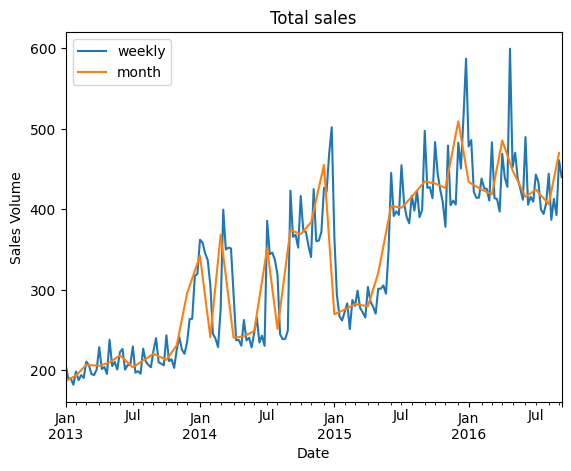

In [29]:
y_train.resample('W').mean().plot(title='Total sales', ylabel='Sales Volume', xlabel='Date', label='weekly');
y_train.resample('ME').mean().plot(title='Total sales', ylabel='Sales Volume', xlabel='Date', label='month');
plt.legend();

## 3. Prepare the pipeline

A simple setup with XGBoost

### XGBoost

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

model = xgb.XGBRegressor(eval_metric='rmsle')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_pred = model.predict(X_valid)
y_pred = y_pred.clip(min=0) # Clamp negative values to 0 before evaluating RMLSE 

np.sqrt(mean_squared_log_error(y_pred, y_valid))

1.5781366417140608

## 4. Submission

In [25]:
y_test = model.predict(get_date_features(X_test))

submission = pd.DataFrame({
    'id': X_test['id'],  # Assuming 'id' is a column in the test dataset
    'sales': y_test
})

submission.to_csv('submission.csv', index=False)